In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, preprocessing
import time
from sklearn.metrics import accuracy_score,  f1_score, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split, cross_val_score
import random
import time
import collections
import warnings
import os

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

from scipy.stats import pearsonr, spearmanr

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.linear_model import LogisticRegression
import gzip

%matplotlib inline

In [158]:
train_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/tcga_sample_identifiers.tsv', header=0, sep='\t')

KeyboardInterrupt: 

In [21]:
# Scale RNAseq data using zero-one normalization
train_label = train_tcga_df['sample_id']
train_normalize = preprocessing.MinMaxScaler().fit_transform(train_tcga_df.drop(['sample_id'], axis=1))
train_tcga_df_normalized = pd.concat([train_label, pd.DataFrame(train_normalize)], axis=1)

In [25]:
# Scale RNAseq data using zero-one normalization
test_label = test_tcga_df['sample_id']
test_normalie = preprocessing.MinMaxScaler().fit_transform(test_tcga_df.drop(['sample_id'], axis=1))
test_tcga_df_normalized = pd.concat([test_label, pd.DataFrame(test_normalie)], axis=1)

In [27]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, var_layer, mean_layer, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + self.var_layer - K.square(self.mean_layer) - 
                                K.exp(self.var_layer), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [28]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [29]:
class Tybalt():
    """
    Facilitates the training and output of tybalt model trained on TCGA RNAseq gene expression data
    """
    def __init__(self, original_dim, hidden_dim, latent_dim,
                 batch_size, epochs, learning_rate, kappa, beta):
        self.original_dim = original_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.beta = beta

    def build_encoder_layer(self):
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of size `latent_dim`
        # Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
        # and relu activation) are funneled separately
        # Each vector of length `latent_dim` are connected to the rnaseq input tensor
        hidden_dense_linear = Dense(self.hidden_dim, kernel_initializer='glorot_uniform')(self.rnaseq_input)
        hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
        hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

        z_mean_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
        self.z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

        z_log_var_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
        self.z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
        self.z = Lambda(sampling, output_shape=(self.latent_dim, ))([self.z_mean_encoded, self.z_log_var_encoded])
    
    def build_decoder_layer(self):
        # The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.hidden_dim, activation='relu', input_dim=self.latent_dim))
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid'))
        self.rnaseq_reconstruct = self.decoder_model(self.z)
        
    def compile_vae(self):
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = CustomVariationalLayer(self.z_log_var_encoded,
                                           self.z_mean_encoded)([self.rnaseq_input, self.rnaseq_reconstruct])
        self.vae = Model(self.rnaseq_input, vae_layer)
        self.vae.compile(optimizer=adam, loss=None, loss_weights=[self.beta])
        
    def get_summary(self):
        self.vae.summary()
  
    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.vae, to_file=output_file)
        SVG(model_to_dot(self.vae).create(prog='dot', format='svg'))
        
    def train_vae(self):
        self.hist = self.vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=self.epochs,
               batch_size=self.batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)),
               callbacks=[WarmUpCallback(self.beta, self.kappa)])
    
    def visualize_training(self, output_file):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('VAE Loss')
        fig = ax.get_figure()
        fig.savefig(output_file)
        
    def compress(self, df):
        # Model to compress input
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)
        
        # Encode rnaseq into the hidden/latent representation - and save output
        encoded_df = self.encoder.predict_on_batch(df)
        encoded_df = pd.DataFrame(encoded_df, columns=range(1, self.latent_dim + 1),
                                  index=rnaseq_df.index)
        return encoded_df
    
    def get_decoder_weights(self):
        # build a generator that can sample from the learned distribution
        decoder_input = Input(shape=(self.latent_dim, ))  # can generate from any sampled z vector
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)
        weights = []
        for layer in self.decoder.layers:
            weights.append(layer.get_weights())
        return(weights)
    
    def predict(self, df):
        return self.decoder.predict(np.array(df))
    
    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)

# BASIC ANALYSIS FOR K=100

In [30]:
# Set common hyper parameters
rnaseq_train_df = train_tcga_df_normalized.drop(['sample_id'], axis=1)
rnaseq_test_df = test_tcga_df_normalized.drop(['sample_id'], axis=1)

original_dim = rnaseq_train_df.shape[1]
latent_dim = 100
beta = K.variable(0)
epsilon_std = 1.0

# Model A (100 hidden layer size)
model_a_latent_dim = 100
model_a_batch_size = 100
model_a_epochs = 100
model_a_learning_rate = 0.001
model_a_kappa = 1.0

In [32]:
model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)

In [33]:
# Compile Model A
model_a.build_encoder_layer()
model_a.build_decoder_layer()
model_a.compile_vae()
model_a.get_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16148)         0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           1614900     input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 100)           400         dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 100)           0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [34]:
model_a.train_vae()

Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 4488.4282 - val_loss: 5341.8775
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3561.7466 - val_loss: 5363.7049
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3508.6122 - val_loss: 5231.4325
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3481.9265 - val_loss: 5135.9487
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3464.6562 - val_loss: 5079.5334
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3451.8864 - val_loss: 5082.8937
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3442.6015 - val_loss: 5049.0349
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3434.2508 - val_loss: 5036.4276
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3426.8115 - val_loss: 5035.4040
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 18s - loss: 3331.1675 - val_loss: 4905.9640
Epoch 81/100
9954/9954 [==============================] - 18s - loss: 3330.6551 - val_loss: 4887.9459
Epoch 82/100
9954/9954 [==============================] - 17s - loss: 3330.3461 - val_loss: 4886.3906
Epoch 83/100
9954/9954 [==============================] - 17s - loss: 3330.3409 - val_loss: 4900.7334
Epoch 84/100
9954/9954 [==============================] - 17s - loss: 3329.8469 - val_loss: 4885.3137
Epoch 85/100
9954/9954 [==============================] - 18s - loss: 3329.3462 - val_loss: 4892.4075
Epoch 86/100
9954/9954 [==============================] - 17s - loss: 3329.3849 - val_loss: 4893.2600
Epoch 87/100
9954/9954 [==============================] - 18s - loss: 3329.0891 - val_loss: 4887.2968
Epoch 88/100
9954/9954 [==============================] - 17s - loss: 3328.8037 - val_loss: 4898.9662
Epoch 89/100
9954/9954 [==============================] - 17s - loss: 3328.7665 - val_loss: 488

In [35]:
rnaseq_df = pd.concat([rnaseq_train_df, rnaseq_test_df])

model_a_compression = model_a.compress(rnaseq_df)

In [36]:
learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/learning.pdf'
compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/compress.tsv'
encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/encoder_twohidden100_vae.hdf5'
decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/decoder_twohidden100_vae.hdf5'
weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/enc_dec_weights.tsv'

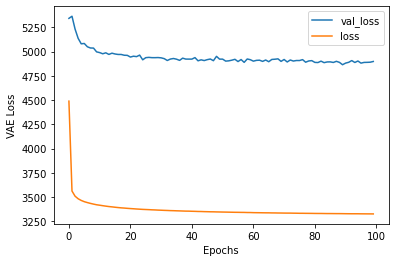

In [37]:
model_a.visualize_training(learning_path)

In [38]:
model_a_weights = model_a.get_decoder_weights()

In [39]:
model_a_compression.to_csv(compress_path, sep='\t', compression='gzip')
model_a.save_models(encoder_path, decoder_path)

In [40]:
def extract_weights(weights, weight_file, k):
    # Multiply hidden layers together to obtain a single representation of gene weights
    intermediate_weight_df = pd.DataFrame(weights[1][0])
    hidden_weight_df = pd.DataFrame(weights[1][2])
    abstracted_weight_df = intermediate_weight_df.dot(hidden_weight_df)

    abstracted_weight_df.index = range(1, k+1)
    abstracted_weight_df.columns = rnaseq_df.columns
    abstracted_weight_df.to_csv(weight_file, sep='\t')

In [42]:
compress_data = model_a_compression
full_data = rnaseq_df

reconstructed_data = pd.DataFrame(model_a.predict(compress_data))

full_data_check = full_data

r = [pearsonr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]

s = [spearmanr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]
print(r)
print(s)

[0.9465984849899136, 0.8976422091268619, 0.934437811525692, 0.941103892459609, 0.8875035103808945, 0.9402255633195212, 0.9530970492593479, 0.9318745159646948, 0.945979670979314, 0.8628509535408999, 0.8803015290075182, 0.9519612793777984, 0.9611219637708917, 0.9636368279478761, 0.9647319520921334, 0.9095505839759279, 0.9037678914534983, 0.937024559006392, 0.9496309278830085, 0.9490860780334638, 0.9454854918872054, 0.9666609415601962, 0.9813060780652365, 0.8473690035696597, 0.9319703548416474, 0.9043118691153897, 0.9261416124756154, 0.9331486420736627, 0.9481860079734217, 0.8847469435057153, 0.9237798694498927, 0.9238242254773299, 0.9240720270648013, 0.9689519619641, 0.950872550889152, 0.9453823590658428, 0.8716331528761203, 0.9385155565543504, 0.9190670924403734, 0.9571711666371765, 0.8548804566949376, 0.9325669758352104, 0.8491347380513823, 0.9301686002303572, 0.8490141033472502, 0.9526454907671739, 0.9381745389380111, 0.9433665143832861, 0.9133992098083265, 0.9496839455186481, 0.87227

In [43]:
print(np.mean(r))

print(np.mean(s))

0.8997658655046805
0.9447158374543674


In [45]:
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))

In [48]:
mse = np.sum((full_data_check - reconstructed_data) ** 2, axis=1).mean()
bce = approx_keras_binary_cross_entropy(full_data_check, reconstructed_data, 100)

print(mse)
print(bce)

36.34773301264385
21.413660140934013


# ONE-VS-ALL LR CLASSIFIER

In [49]:
def runLR(df2, test2):
    time_laps = []
    for i in range(4):
        start_time = time.time()
        clf = LogisticRegression(random_state=0).fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
        pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
        accuracy = accuracy_score(test2.cancer_type,pred)
        laps = time.time() - start_time
        time_laps.append(laps)
    avg_time_laps = np.mean(time_laps)
    SVM_accuracy = accuracy
    SVM_computation_time = avg_time_laps
    return SVM_accuracy, SVM_computation_time

In [50]:
def returnDf2(c_type, df2):
    fraction = collections.Counter(merge_train)[c_type]/len(merge_train)

    df2_0 = df2[df2.cancer_type!=c_type]
    df2_0.loc[:,"cancer_type"] = 0
    df2_0 = df2_0.sample(frac = fraction)

    df2_1 = df2[df2.cancer_type==c_type]
    df2_1.loc[:,"cancer_type"] = 1
    
    #print(df2_0)
    #print(df2_1)
    
    df2 = pd.concat([df2_0, df2_1])
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [75]:
train_id = train_tcga_df_normalized['sample_id']
test_id = test_tcga_df_normalized['sample_id']
label_id = labels_tcga_df['sample_id']

merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

In [79]:
all_labels = pd.DataFrame(np.concatenate((merge_train, merge_test), axis=0), columns=['cancer_type'])
reconstructed_data_label = pd.concat([reconstructed_data, all_labels], axis=1)

In [81]:
compress_data = pd.DataFrame(np.array(compress_data))
compressed_data_label = pd.concat([compress_data, all_labels], axis=1)

In [104]:
full_data = pd.DataFrame(np.array(full_data))

full_data_label = pd.concat([full_data, all_labels], axis=1)#.drop(['level_0', 'index'], axis=1)

In [106]:
train_full, test_full = train_test_split(full_data_label, test_size=0.1)
train_compress, test_compress = train_test_split(compressed_data_label, test_size=0.1)
train_reconstructed, test_reconstructed = train_test_split(reconstructed_data_label, test_size=0.1)

In [107]:
c_type_list = collections.Counter(merge_train)
#c_type_list = ['LUAD', 'LGG', 'PRAD', 'STAD']
#c_type_list = ['DLBC']

cols = ['cancer_type', 'Full-data acc.', 'Full-data comp. time','compress acc.','compress comp. time', 'VAE-reconst. acc.', 'VAE-reconst. time.']
results_df = pd.DataFrame(columns = cols)
i = 0
for c_type in c_type_list:
    train_full_ova = returnDf2(c_type, train_full)
    test_full_ova = returnDf2(c_type, test_full)
    train_compress_ova = returnDf2(c_type, train_compress)
    test_compress_ova = returnDf2(c_type, test_compress)
    train_reconstructed_ova = returnDf2(c_type, train_reconstructed)
    test_reconstructed_ova = returnDf2(c_type, test_reconstructed)
    full_acc, full_time = runLR(train_full_ova, test_full_ova)
    compress_acc, compress_time = runLR(train_compress_ova, test_compress_ova)
    full_reconstructed_acc, full_reconstructed_time = runLR(train_reconstructed_ova, test_reconstructed_ova)
    results_df.loc[i] = [c_type, full_acc,full_time,compress_acc,compress_time, full_reconstructed_acc,full_reconstructed_time]
    i = i+1

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [372]:
my_res = results_df.copy()
my_res = my_res.drop(['VAE-reconst. acc.', 'VAE-reconst. time.'], axis=1)
my_res.columns = ['cancer_type', 'Full-data accuracy', 'Full-data computation time(sec)', 'VAE accuracy', 'VAE computation time(sec)']
my_res.head(10)

,cancer_type,Full-data accuracy,Full-data computation time(sec),VAE accuracy,VAE computation time(sec)
0,BRCA,0.995392,4.200271,0.986957,0.072058
1,LUAD,0.990909,2.186904,1.000000,0.048122
2,DLBC,1.000000,0.481713,1.000000,0.019697
3,UCEC,1.000000,2.339745,0.982609,0.046875
4,SKCM,0.977528,1.823625,0.989583,0.065575
5,PRAD,1.000000,1.687988,1.000000,0.037151
6,HNSC,1.000000,1.954026,0.981982,0.047374
7,KIRP,1.000000,1.573793,0.954545,0.044630
8,CESC,1.000000,1.539634,0.983871,0.045379
9,THCA,1.000000,1.620418,1.000000,0.035904


# PEARSON, SPEARMAN, MSE AND BCE OVER K

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_7" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 21s - loss: 7029.8871 - val_loss: 6676.9750
Epoch 2/100
9954/9954 [==============================] - 28s - loss: 4021.4348 - val_loss: 5659.1588
Epoch 3/100
9954/9954 [==============================] - 18s - loss: 3753.8380 - val_loss: 5356.8611
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3652.2201 - val_loss: 5354.6729
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3601.2556 - val_loss: 5302.1283
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3573.7334 - val_loss: 5293.4227
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3558.9386 - val_loss: 5292.3840
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3550.8204 - val_loss: 5290.2942
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3545.3195 - val_loss: 5290.5623
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 17s - loss: 3470.0452 - val_loss: 5183.2914
Epoch 81/100
9954/9954 [==============================] - 17s - loss: 3469.5026 - val_loss: 5174.4715
Epoch 82/100
9954/9954 [==============================] - 17s - loss: 3469.0586 - val_loss: 5183.6753
Epoch 83/100
9954/9954 [==============================] - 17s - loss: 3468.2791 - val_loss: 5183.5058
Epoch 84/100
9954/9954 [==============================] - 17s - loss: 3467.6219 - val_loss: 5169.0759
Epoch 85/100
9954/9954 [==============================] - 17s - loss: 3467.7151 - val_loss: 5219.7258
Epoch 86/100
9954/9954 [==============================] - 17s - loss: 3466.8596 - val_loss: 5191.5981
Epoch 87/100
9954/9954 [==============================] - 17s - loss: 3466.2008 - val_loss: 5174.9072
Epoch 88/100
9954/9954 [==============================] - 17s - loss: 3465.9815 - val_loss: 5178.0169
Epoch 89/100
9954/9954 [==============================] - 17s - loss: 3465.8487 - val_loss: 517

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_8" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 6141.2653 - val_loss: 6265.3848
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3813.1930 - val_loss: 5527.4706
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3697.0500 - val_loss: 5363.4504
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3660.9209 - val_loss: 5386.8974
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3635.1032 - val_loss: 5313.4074
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3614.2244 - val_loss: 5269.3583
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3591.9934 - val_loss: 5243.8845
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3577.4831 - val_loss: 5234.7575
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3559.6283 - val_loss: 5225.9264
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 19s - loss: 3403.1592 - val_loss: 5075.8706
Epoch 81/100
9954/9954 [==============================] - 18s - loss: 3402.7540 - val_loss: 5051.2077
Epoch 82/100
9954/9954 [==============================] - 18s - loss: 3402.2754 - val_loss: 5074.1098
Epoch 83/100
9954/9954 [==============================] - 18s - loss: 3401.8750 - val_loss: 5048.1368
Epoch 84/100
9954/9954 [==============================] - 18s - loss: 3400.6452 - val_loss: 5061.4624
Epoch 85/100
9954/9954 [==============================] - 18s - loss: 3400.4171 - val_loss: 5051.3337
Epoch 86/100
9954/9954 [==============================] - 18s - loss: 3400.4890 - val_loss: 5076.4324
Epoch 87/100
9954/9954 [==============================] - 18s - loss: 3399.7912 - val_loss: 5069.8016
Epoch 88/100
9954/9954 [==============================] - 18s - loss: 3399.3416 - val_loss: 5068.4978
Epoch 89/100
9954/9954 [==============================] - 18s - loss: 3398.8858 - val_loss: 505

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_9" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_9" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 5568.1648 - val_loss: 5654.4008
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3716.9419 - val_loss: 5328.9367
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3637.9564 - val_loss: 5260.4279
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3604.4531 - val_loss: 5264.8811
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3583.3067 - val_loss: 5238.4118
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3567.6668 - val_loss: 5230.4049
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3554.8030 - val_loss: 5218.8891
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3541.8481 - val_loss: 5195.6260
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3533.6338 - val_loss: 5183.0145
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 18s - loss: 3371.3904 - val_loss: 4985.6055
Epoch 81/100
9954/9954 [==============================] - 18s - loss: 3371.0060 - val_loss: 4993.3594
Epoch 82/100
9954/9954 [==============================] - 18s - loss: 3370.5348 - val_loss: 4991.4835
Epoch 83/100
9954/9954 [==============================] - 18s - loss: 3370.2577 - val_loss: 4988.7008
Epoch 84/100
9954/9954 [==============================] - 18s - loss: 3370.1346 - val_loss: 4995.1825
Epoch 85/100
9954/9954 [==============================] - 18s - loss: 3369.4699 - val_loss: 4980.2080
Epoch 86/100
9954/9954 [==============================] - 18s - loss: 3369.4397 - val_loss: 4974.7099
Epoch 87/100
9954/9954 [==============================] - 18s - loss: 3369.2348 - val_loss: 4991.5891
Epoch 88/100
9954/9954 [==============================] - 18s - loss: 3368.3522 - val_loss: 5000.2165
Epoch 89/100
9954/9954 [==============================] - 18s - loss: 3368.3025 - val_loss: 500

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_10" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_10" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 5172.5641 - val_loss: 6089.9974
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3643.6132 - val_loss: 5334.7951
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3582.1544 - val_loss: 5234.2009
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3553.3504 - val_loss: 5167.5117
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3534.7666 - val_loss: 5167.5987
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3520.5784 - val_loss: 5129.0101
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3508.3573 - val_loss: 5119.9229
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3497.1738 - val_loss: 5103.9687
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3488.7389 - val_loss: 5099.3502
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 18s - loss: 3352.8785 - val_loss: 4947.2781
Epoch 81/100
9954/9954 [==============================] - 18s - loss: 3352.1696 - val_loss: 4961.0017
Epoch 82/100
9954/9954 [==============================] - 18s - loss: 3351.9324 - val_loss: 4959.9701
Epoch 83/100
9954/9954 [==============================] - 18s - loss: 3351.7305 - val_loss: 4948.0993
Epoch 84/100
9954/9954 [==============================] - 18s - loss: 3351.4200 - val_loss: 4967.3799
Epoch 85/100
9954/9954 [==============================] - 18s - loss: 3351.4703 - val_loss: 4964.7644
Epoch 86/100
9954/9954 [==============================] - 18s - loss: 3351.0185 - val_loss: 4948.6726
Epoch 87/100
9954/9954 [==============================] - 18s - loss: 3350.5691 - val_loss: 4964.2213
Epoch 88/100
9954/9954 [==============================] - 18s - loss: 3350.1673 - val_loss: 4964.0156
Epoch 89/100
9954/9954 [==============================] - 18s - loss: 3349.9406 - val_loss: 494

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_11" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_11" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 4729.9600 - val_loss: 5385.4071
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3590.2958 - val_loss: 5259.8097
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3535.1239 - val_loss: 5218.6290
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3508.9237 - val_loss: 5168.7014
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3490.2557 - val_loss: 5153.0752
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3475.9136 - val_loss: 5114.0490
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3466.2898 - val_loss: 5118.7430
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3457.2543 - val_loss: 5107.1438
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3448.5648 - val_loss: 5095.9574
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 17s - loss: 3336.7713 - val_loss: 4941.0599
Epoch 81/100
9954/9954 [==============================] - 17s - loss: 3336.4667 - val_loss: 4939.8927
Epoch 82/100
9954/9954 [==============================] - 17s - loss: 3336.3072 - val_loss: 4952.3681
Epoch 83/100
9954/9954 [==============================] - 17s - loss: 3335.9979 - val_loss: 4947.0706
Epoch 84/100
9954/9954 [==============================] - 17s - loss: 3335.2995 - val_loss: 4929.9708
Epoch 85/100
9954/9954 [==============================] - 17s - loss: 3335.4044 - val_loss: 4942.8550
Epoch 86/100
9954/9954 [==============================] - 17s - loss: 3334.8586 - val_loss: 4959.3654
Epoch 87/100
9954/9954 [==============================] - 17s - loss: 3334.7342 - val_loss: 4952.1825
Epoch 88/100
9954/9954 [==============================] - 17s - loss: 3334.3037 - val_loss: 4941.9633
Epoch 89/100
9954/9954 [==============================] - 17s - loss: 3334.1165 - val_loss: 494

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_12" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 19s - loss: 4469.8346 - val_loss: 5350.4455
Epoch 2/100
9954/9954 [==============================] - 17s - loss: 3561.3782 - val_loss: 5284.8668
Epoch 3/100
9954/9954 [==============================] - 17s - loss: 3510.0591 - val_loss: 5210.2987
Epoch 4/100
9954/9954 [==============================] - 17s - loss: 3481.7214 - val_loss: 5137.6197
Epoch 5/100
9954/9954 [==============================] - 17s - loss: 3464.7671 - val_loss: 5126.6243
Epoch 6/100
9954/9954 [==============================] - 17s - loss: 3452.5802 - val_loss: 5095.5878
Epoch 7/100
9954/9954 [==============================] - 17s - loss: 3441.4302 - val_loss: 5074.5825
Epoch 8/100
9954/9954 [==============================] - 17s - loss: 3433.5658 - val_loss: 5057.7509
Epoch 9/100
9954/9954 [==============================] - 17s - loss: 3426.9232 - val_loss: 5033.6219
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 19s - loss: 3331.5737 - val_loss: 4886.0187
Epoch 81/100
9954/9954 [==============================] - 19s - loss: 3331.3033 - val_loss: 4911.7096
Epoch 82/100
9954/9954 [==============================] - 19s - loss: 3330.7880 - val_loss: 4873.0213
Epoch 83/100
9954/9954 [==============================] - 19s - loss: 3330.5653 - val_loss: 4869.2993
Epoch 84/100
9954/9954 [==============================] - 19s - loss: 3330.3178 - val_loss: 4891.6754
Epoch 85/100
9954/9954 [==============================] - 20s - loss: 3329.8091 - val_loss: 4891.0483
Epoch 86/100
9954/9954 [==============================] - 19s - loss: 3329.5508 - val_loss: 4870.4622
Epoch 87/100
9954/9954 [==============================] - 19s - loss: 3329.4415 - val_loss: 4890.0806
Epoch 88/100
9954/9954 [==============================] - 18s - loss: 3329.2433 - val_loss: 4875.9901
Epoch 89/100
9954/9954 [==============================] - 18s - loss: 3328.6857 - val_loss: 489

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_13" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_13" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 18s - loss: 4360.8259 - val_loss: 5296.4629
Epoch 2/100
9954/9954 [==============================] - 18s - loss: 3544.8106 - val_loss: 5245.4031
Epoch 3/100
9954/9954 [==============================] - 18s - loss: 3495.7199 - val_loss: 5169.9083
Epoch 4/100
9954/9954 [==============================] - 18s - loss: 3469.4103 - val_loss: 5113.9829
Epoch 5/100
9954/9954 [==============================] - 18s - loss: 3452.2058 - val_loss: 5112.3601
Epoch 6/100
9954/9954 [==============================] - 18s - loss: 3440.6989 - val_loss: 5065.0327
Epoch 7/100
9954/9954 [==============================] - 18s - loss: 3431.4245 - val_loss: 5094.0716
Epoch 8/100
9954/9954 [==============================] - 18s - loss: 3422.5702 - val_loss: 5049.5975
Epoch 9/100
9954/9954 [==============================] - 18s - loss: 3416.0906 - val_loss: 5012.6780
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 18s - loss: 3328.9347 - val_loss: 4873.8337
Epoch 81/100
9954/9954 [==============================] - 18s - loss: 3328.2697 - val_loss: 4868.5846
Epoch 82/100
9954/9954 [==============================] - 18s - loss: 3328.1700 - val_loss: 4886.4256
Epoch 83/100
9954/9954 [==============================] - 18s - loss: 3327.7691 - val_loss: 4901.2821
Epoch 84/100
9954/9954 [==============================] - 18s - loss: 3327.3429 - val_loss: 4870.9706
Epoch 85/100
9954/9954 [==============================] - 18s - loss: 3327.3323 - val_loss: 4857.8620
Epoch 86/100
9954/9954 [==============================] - 18s - loss: 3327.1983 - val_loss: 4873.4368
Epoch 87/100
9954/9954 [==============================] - 18s - loss: 3326.8786 - val_loss: 4834.9355
Epoch 88/100
9954/9954 [==============================] - 17s - loss: 3326.4859 - val_loss: 4863.0031
Epoch 89/100
9954/9954 [==============================] - 18s - loss: 3326.1581 - val_loss: 486

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_14" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_14" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 20s - loss: 4307.3531 - val_loss: 5285.1205
Epoch 2/100
9954/9954 [==============================] - 18s - loss: 3531.9337 - val_loss: 5230.1505
Epoch 3/100
9954/9954 [==============================] - 18s - loss: 3482.9284 - val_loss: 5194.6327
Epoch 4/100
9954/9954 [==============================] - 18s - loss: 3457.8691 - val_loss: 5160.4914
Epoch 5/100
9954/9954 [==============================] - 18s - loss: 3442.1567 - val_loss: 5101.3404
Epoch 6/100
9954/9954 [==============================] - 18s - loss: 3430.3297 - val_loss: 5083.6306
Epoch 7/100
9954/9954 [==============================] - 19s - loss: 3420.1153 - val_loss: 5098.6224
Epoch 8/100
9954/9954 [==============================] - 19s - loss: 3412.6466 - val_loss: 5060.3022
Epoch 9/100
9954/9954 [==============================] - 19s - loss: 3406.7878 - val_loss: 5024.8909
Epoch 10/100
9954/9954 [===================

9954/9954 [==============================] - 18s - loss: 3328.0476 - val_loss: 4878.9082
Epoch 81/100
9954/9954 [==============================] - 19s - loss: 3327.8413 - val_loss: 4886.9408
Epoch 82/100
9954/9954 [==============================] - 19s - loss: 3327.5052 - val_loss: 4907.5013
Epoch 83/100
9954/9954 [==============================] - 19s - loss: 3327.5404 - val_loss: 4848.6393
Epoch 84/100
9954/9954 [==============================] - 19s - loss: 3327.1749 - val_loss: 4911.9193
Epoch 85/100
9954/9954 [==============================] - 19s - loss: 3326.8243 - val_loss: 4870.3381
Epoch 86/100
9954/9954 [==============================] - 19s - loss: 3326.7443 - val_loss: 4868.3045
Epoch 87/100
9954/9954 [==============================] - 19s - loss: 3326.4990 - val_loss: 4869.9153
Epoch 88/100
9954/9954 [==============================] - 19s - loss: 3325.9886 - val_loss: 4872.7033
Epoch 89/100
9954/9954 [==============================] - 19s - loss: 3326.0034 - val_loss: 485

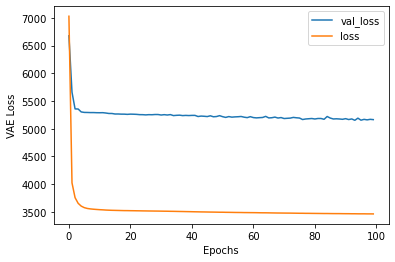

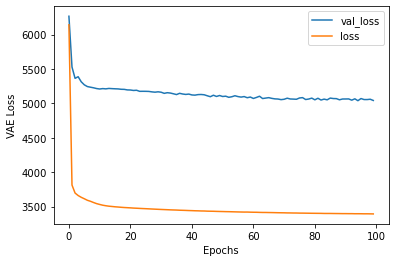

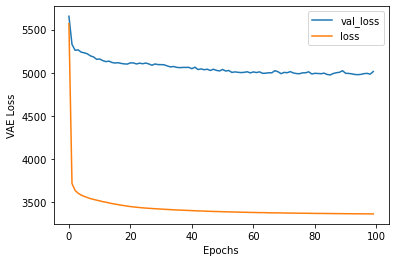

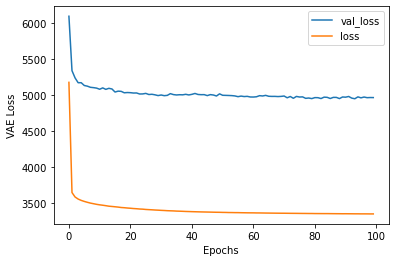

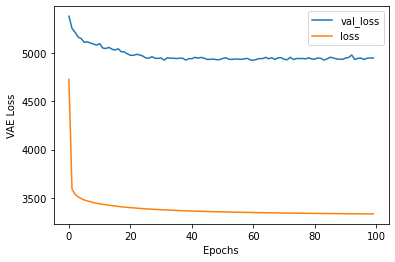

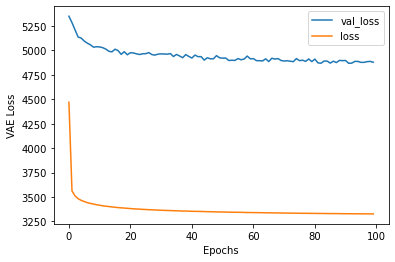

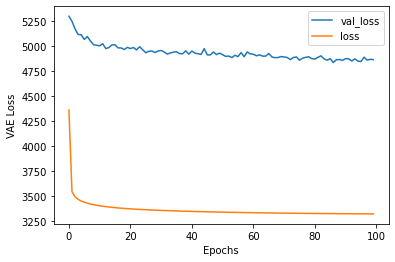

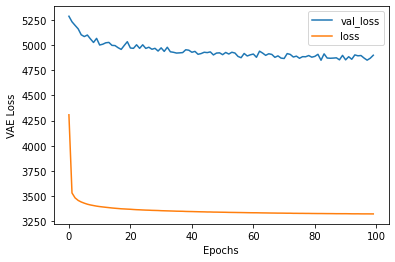

In [118]:
list_k = [2, 5, 10, 20, 50, 100, 150, 200]

list_pearson = []
list_spearman = []
list_mse = []
list_bce = []

for k in list_k:
    # Set common hyper parameters
    rnaseq_train_df = train_tcga_df_normalized.drop(['sample_id'], axis=1)
    rnaseq_test_df = test_tcga_df_normalized.drop(['sample_id'], axis=1)

    original_dim = rnaseq_train_df.shape[1]
    latent_dim = k
    beta = K.variable(0)
    epsilon_std = 1.0

    # Model A (100 hidden layer size)
    model_a_latent_dim = 100
    model_a_batch_size = 100
    model_a_epochs = 100
    model_a_learning_rate = 0.001
    model_a_kappa = 1.0
    
    model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)
    
    # Compile Model A
    model_a.build_encoder_layer()
    model_a.build_decoder_layer()
    model_a.compile_vae()
    
    model_a.train_vae()
    
    rnaseq_df = pd.concat([rnaseq_train_df, rnaseq_test_df])

    model_a_compression = model_a.compress(rnaseq_df)
    
    learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/figure/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_learning.pdf'
    compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/models/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_compress.tsv'
    encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/models/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_encoder_twohidden100_vae.hdf5'
    decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/models/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_decoder_twohidden100_vae.hdf5'
    weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/models/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_enc_dec_weights.tsv'
    
    model_a.visualize_training(learning_path)
    
    model_a_weights = model_a.get_decoder_weights()
    
    model_a_compression.to_csv(compress_path, sep='\t', compression='gzip')
    model_a.save_models(encoder_path, decoder_path)
    
    extract_weights(model_a_weights, weight_path, k)
    
    compress_data = model_a_compression
    full_data = rnaseq_df
    
    compress_data = model_a_compression
    full_data = rnaseq_df

    reconstructed_data = pd.DataFrame(model_a.predict(compress_data))

    full_data_check = full_data

    r = [pearsonr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]
    s = [spearmanr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])] 
    mse = np.sum((full_data_check - reconstructed_data) ** 2, axis=1).mean()
    bce = approx_keras_binary_cross_entropy(full_data_check, reconstructed_data, k)
    
    list_pearson.append(r)
    list_spearman.append(s)
    list_mse.append(mse)
    list_bce.append(bce)

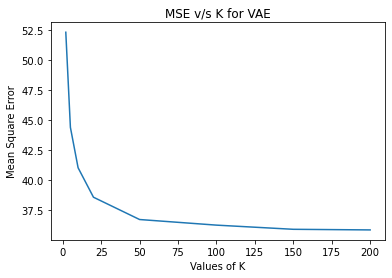

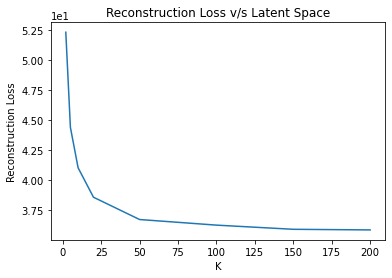

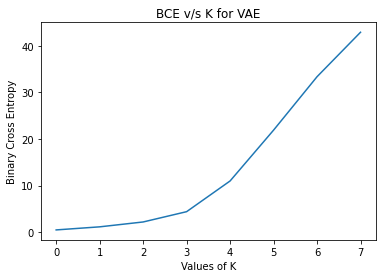

In [366]:
list_bce.append(bce)
plt.title('MSE v/s K for VAE')
plt.xlabel('Values of K')
plt.ylabel('Mean Square Error')
plt.plot(list_k, list_mse)
plt.show()


plt.plot(list_k, list_mse)
# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss v/s Latent Space')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

plt.title('BCE v/s K for VAE')
plt.xlabel('Values of K')
plt.ylabel('Binary Cross Entropy')
plt.plot(list_bce[:8])
plt.show()

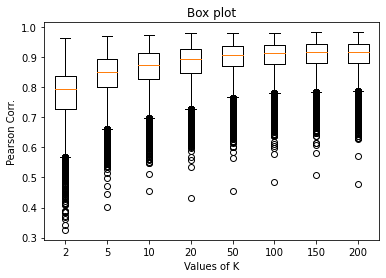

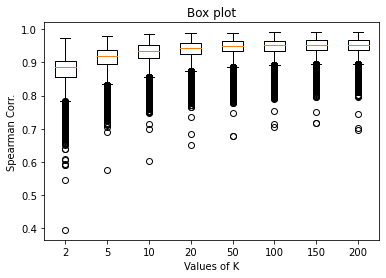

In [120]:
list_pearson = np.array(list_pearson)
list_spearman = np.array(list_spearman)
# print(np.mean(list_pearson, axis=1))
# print(np.mean(list_spearman, axis=1))

plt.title('Box plot')
plt.xlabel('Values of K')
plt.ylabel('Pearson Corr.')
plt.boxplot(list_pearson.transpose(), labels=list_k)
plt.show()

plt.title('Box plot')

plt.xlabel('Values of K')
plt.ylabel('Spearman Corr.')
plt.boxplot(list_spearman.transpose(), labels=list_k)
plt.show()

In [121]:
# specific cancer type selection
list_label = np.array(all_labels)
c_type_list = collections.Counter(merge_train)

for c_type in c_type_list:
    pearson_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/figure/c_type_vae/fig__pearson_'+c_type+'.png'
    spearman_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/figure/c_type_vae/fig__spearman_'+c_type+'.png'
    c_pearson = []
    c_spearman = []
    for i in range(len(list_label)):
        if c_type == list_label[i]:
            c_pearson.append(list_pearson[:,i])
            c_spearman.append(list_spearman[:,i])

    c_pearson = np.array(c_pearson)
    c_spearman = np.array(c_spearman)

    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+str(c_type)) 
    ax.set_xlabel('Values of k') 
    ax.set_ylabel('Peason Corr.') 
    ax.boxplot(c_pearson, labels=list_k) 
    fig.savefig(pearson_path)
    fig.clear(True) 


    fig2, ax2 = plt.subplots() 
    fig2.suptitle('Box plot for '+str(c_type)) 
    ax2.set_xlabel('Values of k') 
    ax2.set_ylabel('Spearman Corr.') 
    ax2.boxplot(c_spearman, labels=list_k) 
    fig2.savefig(spearman_path)
    fig2.clear(True)

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# SAVE COMPRESS DATA FOR CLASSIFICATION

In [139]:
def align_labels(df):    
    df = pd.concat([df, all_labels], axis=1)
    return df

In [142]:
list_k = [2, 5, 10, 20, 50, 100, 150, 200]
for k in list_k:
    compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/models/k_'+str(k)+'_epoch_'+str(model_a_epochs)+'_compress.tsv'
    save_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/data/k_'+str(k)+'_compress_for_classifier.tsv'

    enc_model = load_model(encoder_path)
    dec_model = load_model(decoder_path)
    
    with open(compress_path, 'rb') as fd:
        gzip_fd = gzip.GzipFile(fileobj=fd)
        compress_data = pd.read_csv(gzip_fd, sep='\t')
    
    compress_data = compress_data.drop(compress_data.columns[0], axis=1)
    compress_data = align_labels(compress_data)
    compress_data.to_csv(save_path, sep='\t', compression='gzip')

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\keras\models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# COMPRESSED FEATURES ENSEMBLE LR MULTICLASS CLASSIFICATION

In [161]:
k=50

# PCA calculation
pca = PCA(n_components=k)

# PCA Model Fitting
pca_train = pca.fit_transform(rnaseq_train_df)
pca_test = pca.fit_transform(rnaseq_test_df)

# NMF calculation
nmf = NMF(n_components=k)

# NMF Model Fitting
nmf_train = nmf.fit_transform(rnaseq_train_df)
nmf_test = nmf.fit_transform(rnaseq_test_df)

# ICA calculation
ica = FastICA(n_components=k)

# ICA Model Fitting for Train Set
ica_train = ica.fit_transform(rnaseq_train_df)
ica_test = ica.fit_transform(rnaseq_test_df)

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [183]:
#VAE compress feature load for k=100
k=100
load_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/data/k_'+str(k)+'_compress_for_classifier.tsv'
with open(load_path, 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    vae_data = pd.read_csv(gzip_fd, sep='\t')

In [225]:
vae_all = vae_data.drop(vae_data.columns[0], axis=1)
vae_train = vae_all[0:9954]
vae_test = vae_all[9954:]

In [245]:
pca_train_df = pd.DataFrame(pca_train)
nmf_train_df = pd.DataFrame(nmf_train)
ica_train_df = pd.DataFrame(ica_train)

pca_test_df = pd.DataFrame(pca_test)
nmf_test_df = pd.DataFrame(nmf_test)
ica_test_df = pd.DataFrame(ica_test)
vae_test = pd.DataFrame(np.array(vae_test))

columns = [i+1 for i in range(250)]
columns.append('cancer_type')

ensemble_train = pd.concat([pca_train_df, nmf_train_df, ica_train_df, vae_train], axis=1)
ensemble_train.columns = columns

ensemble_test = pd.concat([pca_test_df, nmf_test_df, ica_test_df, vae_test], axis=1)
ensemble_test.columns = columns

train_label_df = pd.DataFrame(merge_train, columns=['cancer_type'])
test_label_df = pd.DataFrame(merge_test, columns=['cancer_type'])

full_train = pd.concat([rnaseq_train_df, train_label_df], axis=1)
full_test = pd.concat([rnaseq_test_df, test_label_df], axis=1)

only_pca_train = pd.concat([pca_train_df, train_label_df], axis=1)
only_pca_test = pd.concat([pca_test_df, test_label_df], axis=1)

only_nmf_train = pd.concat([nmf_train_df, train_label_df], axis=1)
only_nmf_test = pd.concat([nmf_test_df, test_label_df], axis=1)

only_ica_train = pd.concat([ica_train_df, train_label_df], axis=1)
only_ica_test = pd.concat([ica_test_df, test_label_df], axis=1)

In [340]:
save_path_train = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/data/ensemble_train.tsv'
save_path_test = 'D://GitHub/Gene-compression-and-Cancer-type-classification/normalize/data/ensemble_test.tsv'

ensemble_train.to_csv(save_path_train, sep='\t', compression='gzip')
ensemble_test.to_csv(save_path_test, sep='\t', compression='gzip')

In [239]:
def prepare_multiclass(c_type_list, df2):
    df_main = df2[df2.cancer_type==c_type_list[0]]
    df_main.loc[:,"cancer_type"] = 0
    
    for i in range(1,len(c_type_list)):
        c_type = c_type_list[i]
        df2_temp = df2[df2.cancer_type==c_type]
        df2_temp.loc[:,"cancer_type"] = i
        df_main = pd.concat([df_main, df2_temp])
        
    df2 = df_main
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [278]:
def runLRMulticlass(df2, test2):
    time_laps = []
    for i in range(4):
        start_time = time.time()
        clf = LogisticRegression(random_state=0).fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
        pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
        accuracy = accuracy_score(test2.cancer_type,pred)
        precision, recall, f1score, _= precision_recall_fscore_support(pred, test2.cancer_type)
        laps = time.time() - start_time
        time_laps.append(laps)
    avg_time_laps = np.mean(time_laps)
    SVM_accuracy = accuracy
    SVM_computation_time = avg_time_laps
    return SVM_accuracy, SVM_computation_time, precision, recall, f1score

In [259]:
columns = [i+1 for i in range(100)]
columns.append('cancer_type')

vae_test.columns = columns

In [324]:
#multi_class_list = ['UCEC', 'HNSC', 'SARC', 'ACC', 'LUSC', 'KIRC', 'PCPG', 'LUAD', 'HNSC', 'COAD']
multi_class_list = collections.Counter(merge_train)
multi_class_list = [c_type for c_type in multi_class_list]

cols = ['Accuracy', 'Precision','Recall','F1-score','Computation Time (sec.)', 'K-Dimension']
index = ['Full Data','PCA Features', 'NMF Features','ICA Features','VAE Features','Ensemble Features']
multiclass_result = pd.DataFrame(columns = cols, index=index)

df2_train_full = prepare_multiclass(multi_class_list, full_train)
df2_test_full = prepare_multiclass(multi_class_list, full_test)
full_acc, full_time, precision, recall, f1score = runLRMulticlass(df2_train_full, df2_test_full)
multiclass_result.loc['Full Data'] = [full_acc, precision, recall, f1score,full_time, 16147]

df2_train_pca = prepare_multiclass(multi_class_list, only_pca_train)
df2_test_pca = prepare_multiclass(multi_class_list, only_pca_test)
pca_acc, pca_time, precision, recall, f1score = runLRMulticlass(df2_train_pca, df2_test_pca)
multiclass_result.loc['PCA Features'] = [pca_acc, precision, recall, f1score, pca_time, 50]

df2_train_nmf = prepare_multiclass(multi_class_list, only_nmf_train)
df2_test_nmf = prepare_multiclass(multi_class_list, only_nmf_test)
nmf_acc, nmf_time, precision, recall, f1score = runLRMulticlass(df2_train_nmf, df2_test_nmf)
multiclass_result.loc['NMF Features'] = [nmf_acc, precision, recall, f1score, nmf_time, 50]

df2_train_ica = prepare_multiclass(multi_class_list, only_ica_train)
df2_test_ica = prepare_multiclass(multi_class_list, only_ica_test)
ica_acc, ica_time, precision, recall, f1score = runLRMulticlass(df2_train_ica, df2_test_ica)
multiclass_result.loc['ICA Features'] = [ica_acc, precision, recall, f1score, ica_time, 50]

df2_train_vae = prepare_multiclass(multi_class_list, vae_train)
df2_test_vae = prepare_multiclass(multi_class_list, vae_test)
vae_acc, vae_time, precision, recall, f1score = runLRMulticlass(df2_train_vae, df2_test_vae)
multiclass_result.loc['VAE Features'] = [vae_acc, precision, recall, f1score, vae_time, 100]

df2_train_ensemble = prepare_multiclass(multi_class_list, ensemble_train)
df2_test_ensemble = prepare_multiclass(multi_class_list, ensemble_test)
ensemble_acc, ensemble_time, precision, recall, f1score = runLRMulticlass(df2_train_ensemble, df2_test_ensemble)
multiclass_result.loc['Ensemble Features'] = [ensemble_acc, precision, recall, f1score, ensemble_time, 250]

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [328]:
multiclass_result

,Accuracy,Precision,Recall,F1-score,Computation Time (sec.),K-Dimension
Full Data,0.947559,"[1.0, 1.0, 1.0, 0.9821428571428571, 1.0, 1.0, ...","[1.0, 0.9827586206896551, 1.0, 0.9821428571428...","[1.0, 0.9913043478260869, 1.0, 0.9821428571428...",55.0593,16147
PCA Features,0.289331,"[0.7950819672131147, 0.45614035087719296, 0.0,...","[0.9897959183673469, 0.41935483870967744, 0.0,...","[0.8818181818181818, 0.43697478991596644, 0.0,...",2.82495,50
NMF Features,0.331826,"[0.9754098360655737, 1.0, 0.0, 0.0, 0.04255319...","[1.0, 0.47107438016528924, 0.0, 0.0, 0.1, 1.0,...","[0.9875518672199171, 0.6404494382022472, 0.0, ...",3.06057,50
ICA Features,0.509042,"[1.0, 1.0, 0.0, 1.0, 0.6595744680851063, 0.0, ...","[1.0, 1.0, 0.0, 0.7272727272727273, 0.36046511...","[1.0, 1.0, 0.0, 0.8421052631578948, 0.46616541...",2.77658,50
VAE Features,0.906872,"[0.9672131147540983, 1.0, 1.0, 0.9107142857142...","[0.9833333333333333, 0.8636363636363636, 0.833...","[0.9752066115702478, 0.9268292682926829, 0.909...",2.90972,100
Ensemble Features,0.901447,"[0.9672131147540983, 1.0, 1.0, 0.875, 1.0, 0.9...","[0.9915966386554622, 0.8636363636363636, 0.833...","[0.979253112033195, 0.9268292682926829, 0.9090...",3.63952,250


In [332]:
mean_result_df = multiclass_result.copy()

for index, row in mean_result_df.iterrows():
    row['Precision'] = np.mean(row['Precision'])
    row['Recall'] = np.mean(row['Recall'])
    row['F1-score'] = np.mean(row['F1-score'])

mean_result_df.columns = cols = ['Accuracy', 'Mean Precision','Mean Recall','Mean F1-score','Computation Time (sec.)', 'K-Dimension']

In [333]:
mean_result_df

,Accuracy,Mean Precision,Mean Recall,Mean F1-score,Computation Time (sec.),K-Dimension
Full Data,0.947559,0.878011,0.872873,0.873461,55.0593,16147
PCA Features,0.289331,0.196031,0.164082,0.170341,2.82495,50
NMF Features,0.331826,0.210212,0.192597,0.194684,3.06057,50
ICA Features,0.509042,0.281059,0.190303,0.211253,2.77658,50
VAE Features,0.906872,0.918027,0.889877,0.890345,2.90972,100
Ensemble Features,0.901447,0.917407,0.882543,0.88334,3.63952,250
